## Exercice n°2 (1/2 h)



Télécharger le Visual Transformer (DeiT) hébergé sur Hugging Face à l'adresse :
"facebook/deit-tiny-patch16-224". Répondez aux questions suivantes en vous appuyant sur des éléments de l'architecture ou d'une des fonctions associées au modèle (en particulier la fonction forward()).
- Quelle est la taille de l'espace latent de ce transformer ?
- Comment l'image est-elle tokenisée et en quoi consiste l'embedding (valeurs et position) ?
- Quelle est la signification du premier token ?
- Déterminer et interpréter l'output associé à l'image fournie dans le TP n°2 (cat.jpg) à l'aide de ce modèle.
- Visualiser les scores attentionnels associés au premier token pour les premières têtes de la première couche attentionnelle. Comparer à ce qu'on avait obtenu pour un ResNet50 pré-entraîné sur ImageNet.

# Chargement du transformer

In [1]:
from PIL import Image
import torch
# AutoImageProcessor : normalisation, mise au bon format
from transformers import AutoImageProcessor, ViTForImageClassification

proc = AutoImageProcessor.from_pretrained("facebook/deit-tiny-patch16-224")
model = ViTForImageClassification.from_pretrained("facebook/deit-tiny-patch16-224")
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


pytorch_model.bin:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=192, out_features=768, bias=True)
            (intermedi

# Eléments d'architecture :

- La dimension de l'espace du modèle est 192:

In [ ]:
for k in range(11):
  print(model.vit.encoder.layer[k].attention.attention.query)

Linear(in_features=192, out_features=192, bias=True)
Linear(in_features=192, out_features=192, bias=True)
Linear(in_features=192, out_features=192, bias=True)
Linear(in_features=192, out_features=192, bias=True)
Linear(in_features=192, out_features=192, bias=True)
Linear(in_features=192, out_features=192, bias=True)
Linear(in_features=192, out_features=192, bias=True)
Linear(in_features=192, out_features=192, bias=True)
Linear(in_features=192, out_features=192, bias=True)
Linear(in_features=192, out_features=192, bias=True)
Linear(in_features=192, out_features=192, bias=True)


- Voyons la couche d'embedding. Par une couche de convolution 2d (model.vit.embeddings.patch_embeddings.projection), l'image d'entrée, de taille 224x224, est découpée en 14x14 patchs de taille 16x16 (même taille que les noyaux de convolution). Par application de 192 noyaux de convolution sur chacun des patch, on obtient des vecteurs de taille 192.

In [ ]:
import inspect
print(model.vit.embeddings.patch_embeddings.projection)
print(inspect.getsource(model.vit.embeddings.patch_embeddings.forward))

Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    def forward(self, pixel_values: torch.Tensor, interpolate_pos_encoding: bool = False) -> torch.Tensor:
        batch_size, num_channels, height, width = pixel_values.shape
        if num_channels != self.num_channels:
            raise ValueError(
                "Make sure that the channel dimension of the pixel values match with the one set in the configuration."
                f" Expected {self.num_channels} but got {num_channels}."
            )
        if not interpolate_pos_encoding:
            if height != self.image_size[0] or width != self.image_size[1]:
                raise ValueError(
                    f"Input image size ({height}*{width}) doesn't match model"
                    f" ({self.image_size[0]}*{self.image_size[1]})."
                )
        embeddings = self.projection(pixel_values).flatten(2).transpose(1, 2)
        return embeddings



Ensuite, cette séquence est concaténée avec un token supplémentaire (le "premier token") et on ajoute l'embedding des positions :

In [ ]:
import inspect
print(model.vit.embeddings.patch_embeddings)
print(inspect.getsource(model.vit.embeddings.forward))

ViTPatchEmbeddings(
  (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
)
    def forward(
        self,
        pixel_values: torch.Tensor,
        bool_masked_pos: Optional[torch.BoolTensor] = None,
        interpolate_pos_encoding: bool = False,
    ) -> torch.Tensor:
        batch_size, num_channels, height, width = pixel_values.shape
        embeddings = self.patch_embeddings(pixel_values, interpolate_pos_encoding=interpolate_pos_encoding)

        if bool_masked_pos is not None:
            seq_length = embeddings.shape[1]
            mask_tokens = self.mask_token.expand(batch_size, seq_length, -1)
            # replace the masked visual tokens by mask_tokens
            mask = bool_masked_pos.unsqueeze(-1).type_as(mask_tokens)
            embeddings = embeddings * (1.0 - mask) + mask_tokens * mask

        # add the [CLS] token to the embedded patch tokens
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        embeddings = torch.cat((cls_tokens,

- Ce dernier, codé dans self.position_embeddings par défaut (interpolate_pos_encoding=False par défaut), est composés de vecteurs entraînable (un par position).

In [ ]:
print(model.vit.embeddings.position_embeddings)

Parameter containing:
tensor([[[ 0.0217, -0.0238, -0.7201,  ..., -0.7930,  0.6020,  0.5947],
         [ 1.1578,  0.0398, -0.2418,  ...,  0.3381, -1.0626, -0.9799],
         [ 0.8281,  0.0092, -0.6373,  ...,  0.5310, -0.4761, -0.6640],
         ...,
         [ 0.2172,  0.2119, -0.0446,  ...,  0.9454, -0.0955, -0.3546],
         [ 0.4089,  0.1884,  0.1739,  ...,  0.6313, -0.0297, -0.5622],
         [ 0.6213,  0.0689,  0.8310,  ...,  0.6519, -0.1950, -0.6621]]],
       requires_grad=True)


- le première position est celle qui sera interrgée pour fournir la classification (voir  pooled_output = sequence_output[:, 0, :] dans la cellule suivante).

**N.B.** Codé de cette manière, le transformer ne risque pas de privilégier l'information venant de l'un des patchs en particulier pour décider de la classe.

In [ ]:
import inspect
print(inspect.getsource(model.forward))

    @can_return_tuple
    @auto_docstring
    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        interpolate_pos_encoding: Optional[bool] = None,
        **kwargs: Unpack[TransformersKwargs],
    ) -> ImageClassifierOutput:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the image classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """

        outputs: BaseModelOutputWithPooling = self.vit(
            pixel_values,
            head_mask=head_mask,
            interpolate_pos_encoding=interpolate_pos_encoding,
            **kwargs,
        )

        sequence_out

# Classification de cat.jpg :

In [ ]:
import torch
import requests
from PIL import Image
from io import BytesIO
from transformers import AutoImageProcessor, ViTForImageClassification

# 1) Load image (use raw URL, not "blob")
url = "https://raw.githubusercontent.com/nanopiero/ML_S5_etudiants/main/practicals/P2/cat.jpg"
img = Image.open(BytesIO(requests.get(url).content)).convert("RGB")

# 2) Load DeiT model + processor
ckpt = "facebook/deit-tiny-patch16-224"
processor = AutoImageProcessor.from_pretrained(ckpt)
model = ViTForImageClassification.from_pretrained(ckpt)
model.eval()

# 3) Preprocess -> forward -> logits
inputs = processor(images=img, return_tensors="pt")
with torch.no_grad():
    out = model(**inputs)

logits = out.logits                      # shape: (1, 1000)
probs = torch.softmax(logits, dim=-1)[0] # shape: (1000,)

# 4) Top-5 decode
top5 = torch.topk(probs, k=5)
for p, idx in zip(top5.values.tolist(), top5.indices.tolist()):
    print(f"{idx:4d}  {p:.4f}  {model.config.id2label[idx]}")


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


 285  0.1387  Egyptian cat
 284  0.0772  Siamese cat, Siamese
 283  0.0555  Persian cat
 281  0.0304  tabby, tabby cat
 794  0.0150  shower curtain


# Visualisation des scores attentionnels pour les premières couches

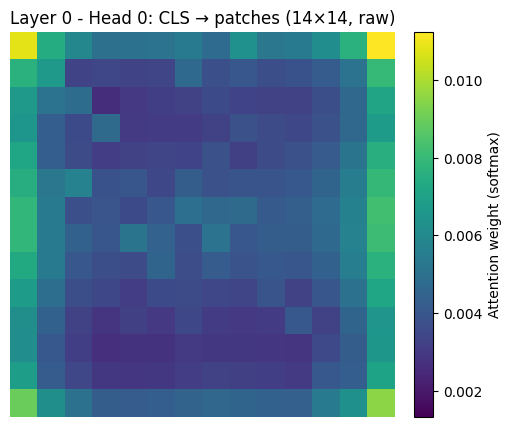

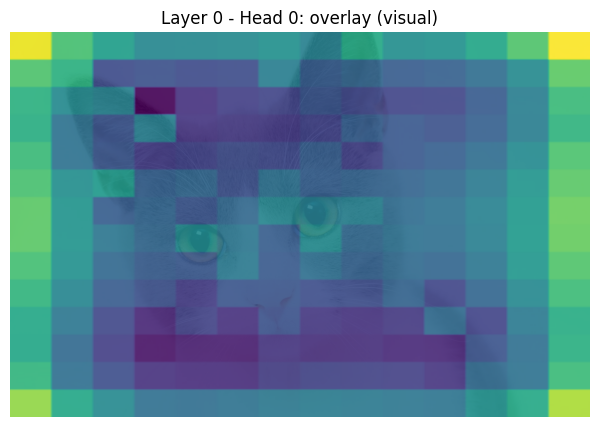

Head 0: min=2.640118e-03, max=1.123576e-02, mean=4.597965e-03 (baseline ~ 0.005102)


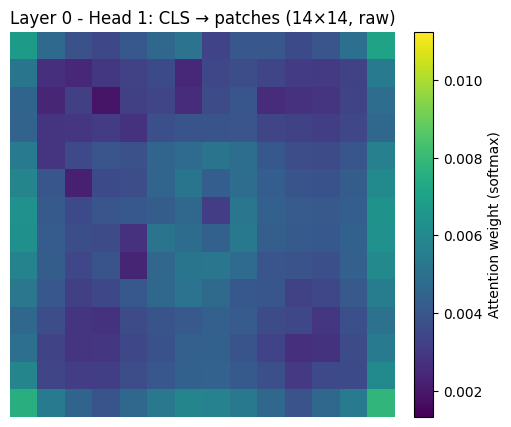

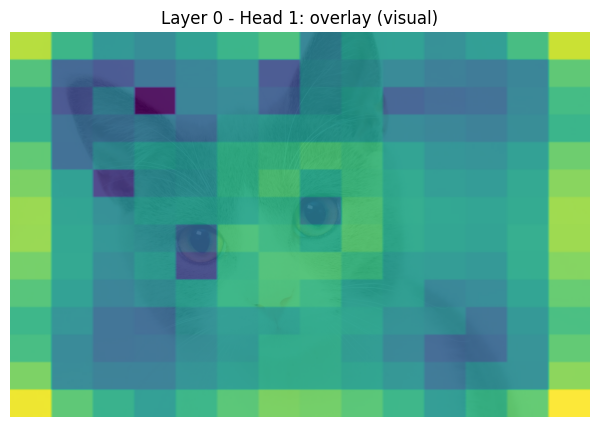

Head 1: min=1.891750e-03, max=7.835944e-03, mean=4.122770e-03 (baseline ~ 0.005102)


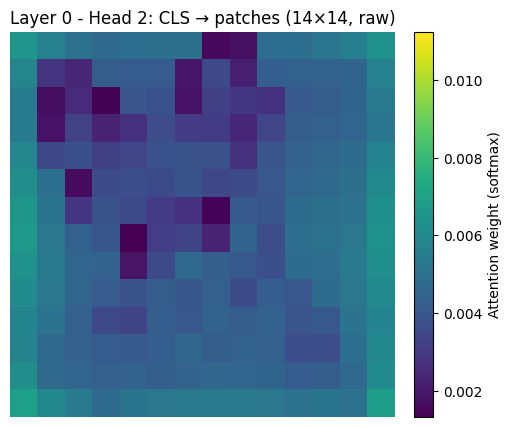

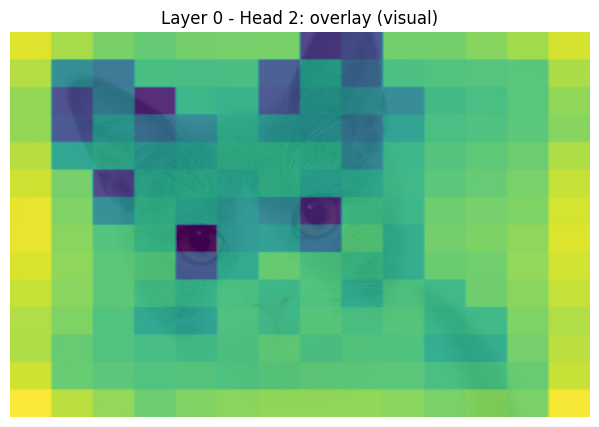

Head 2: min=1.329502e-03, max=6.936327e-03, mean=4.347465e-03 (baseline ~ 0.005102)


In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoImageProcessor, ViTForImageClassification
from PIL import Image
import requests
from io import BytesIO

# --- Load image ---
url = "https://raw.githubusercontent.com/nanopiero/ML_S5_etudiants/main/practicals/P2/cat.jpg"
img = Image.open(BytesIO(requests.get(url).content)).convert("RGB")

# --- Model + processor ---
ckpt = "facebook/deit-tiny-patch16-224"
processor = AutoImageProcessor.from_pretrained(ckpt, use_fast=True)
model = ViTForImageClassification.from_pretrained(ckpt).eval()

# Must be eager to get attentions
model.set_attn_implementation("eager")

# --- Forward with attentions ---
inputs = processor(images=img, return_tensors="pt")
with torch.no_grad():
    out = model(**inputs, output_attentions=True)

if out.attentions is None:
    raise RuntimeError("Attentions are None. Make sure model.set_attn_implementation('eager') was applied.")

att0 = out.attentions[0]  # first layer: (B, H, T, T)
B, H, T, _ = att0.shape

# --- Prepare base image ---
img_np = np.array(img)  # uint8 RGB
Himg, Wimg = img_np.shape[:2]

# DeiT-tiny patch16-224 => 14x14 patches = 196 tokens (plus CLS)
grid = 14
patch = 16
n_patches = grid * grid

# --- Collect 14x14 maps first to use a shared colormap scale (IMPORTANT) ---
heat14_all = []
for h in range(H):
    cls_to_patches = att0[0, h, 0, 1:1+n_patches].detach().cpu().numpy()  # (196,)
    heat14_all.append(cls_to_patches.reshape(grid, grid))

vmin = min(hm.min() for hm in heat14_all)
vmax = max(hm.max() for hm in heat14_all)

def make_overlay(img_np, heat224, alpha=0.85, gamma=0.60):
    """
    img_np: uint8 RGB (H,W,3)
    heat224: float (H,W) attention map (already upsampled to image size)
    alpha: attention weight vs image weight (higher => attention dominates)
    gamma: <1 boosts contrast (hotspots pop; dips also become clearer)
    """
    h = heat224.astype(np.float32)
    h = h - h.min()
    if h.max() > 0:
        h = h / h.max()
    h = np.power(h, gamma)

    cmap = plt.get_cmap()  # default colormap
    heat_rgb = (cmap(h)[..., :3] * 255).astype(np.uint8)
    return (alpha * heat_rgb + (1 - alpha) * img_np).astype(np.uint8)

# --- Visualize: (1) raw heatmap + colorbar, (2) overlay ---
for h in range(3):
    heat14 = heat14_all[h]

    # 1) Raw CLS->patch attention (14x14) with quantitative colorbar
    plt.figure(figsize=(6, 5))
    im = plt.imshow(heat14, vmin=vmin, vmax=vmax)
    plt.title(f"Layer 0 - Head {h}: CLS → patches (14×14, raw)")
    plt.axis("off")
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.set_label("Attention weight (softmax)")
    plt.show()

    # 2) Upsample 14x14 -> 224x224 by repeating 16x16 blocks
    heat224 = np.kron(heat14, np.ones((patch, patch), dtype=np.float32))  # (224,224)

    # If displayed image isn't 224x224, resize heatmap to match
    if heat224.shape != (Himg, Wimg):
        heat_img = Image.fromarray(heat224)
        heat_img = heat_img.resize((Wimg, Himg), resample=Image.BILINEAR)
        heat224 = np.array(heat_img).astype(np.float32)

    overlay = make_overlay(img_np, heat224, alpha=0.90, gamma=0.60)

    plt.figure(figsize=(8, 5))
    plt.title(f"Layer 0 - Head {h}: overlay (visual)")
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

    # Optional numeric sanity check
    print(f"Head {h}: min={heat14.min():.6e}, max={heat14.max():.6e}, mean={heat14.mean():.6e} (baseline ~ {1/n_patches:.6f})")


## Analyse des scores attentionnels – DeiT (première couche)

### Observation
Les scores attentionnels associés au premier token (query) vis-à-vis des tokens correspondant aux patchs (keys) présentent des valeurs relativement plus élevées au niveau des yeux et des contours des oreilles pour certaines têtes (tête 0), tandis que d’autres têtes (tête 2) leur attribuent au contraire des scores nettement plus faibles.  
On observe également des scores relativement plus importants au niveau des bords et des coins de l’image.

### Interprétation
Cette opposition dans l’attention portée aux yeux et aux oreilles traduit vraisemblablement une **spécialisation des têtes attentionnelles**. Les scores plus élevés observés sur ces régions suggèrent que l’information associée à ces structures visuellement distinctives est prioritairement **routée** par certaines têtes dès la première couche, tandis que d’autres têtes jouent un rôle complémentaire en la dé-pondérant.  

Les scores attentionnels plus élevés observés sur les bords et les coins de l’image peuvent être interprétés comme un **rôle d’ancrage spatial**, ces régions fournissant des informations de contexte global et de positionnement utiles à l’agrégation par le token `[CLS]`.

### Comparaison avec ResNet50
Bien que les filtres de la première couche convolutionnelle d’un ResNet50 soient eux aussi spécialisés (cf. TP n°2), ceux-ci effectuent un traitement **strictement local**, principalement associé à la détection de motifs élémentaires tels que les contours et les orientations. À ce stade, l’information issue de différents filtres ne peut pas être combinée spatialement ; ce croisement d’information n’intervient qu’à partir des couches convolutionnelles suivantes.


In [ ]:
-